**Objectives** 

- Deep dive into IPL performance trends (2008–2022)  
- Analyze batting, bowling & team dynamics  
- Study match-winning patterns and toss influence  
- Build a clean & interactive Power BI dashboard  
- Demonstrate ETL + visualization workflow end-to-end 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the ball-by-ball data
df_balls = pd.read_csv("ipl_ball_by_ball_2008_2022.csv")

# Load the match data
df_matches = pd.read_csv("ipl_matches_2008_2022.csv")

In [6]:
# Inspect the ball-by-ball data
print("--- Ball-by-Ball Data (df_balls) ---")
print(df_balls.head().to_markdown(index=False, numalign="left", stralign="left"))
print(df_balls.info())

--- Ball-by-Ball Data (df_balls) ---
| id      | innings   | overs   | ball_number   | batter      | bowler         | non_striker   | extra_type   | batsman_run   | extras_run   | total_run   | non_boundary   | iswicket_delivery   | player_out   | dismisal_kind   | fielders_involved   | batting_team     |
|:--------|:----------|:--------|:--------------|:------------|:---------------|:--------------|:-------------|:--------------|:-------------|:------------|:---------------|:--------------------|:-------------|:----------------|:--------------------|:-----------------|
| 1312200 | 1         | 0       | 1             | YBK Jaiswal | Mohammed Shami | JC Buttler    | nan          | 0             | 0            | 0           | 0              | 0                   | nan          | nan             | nan                 | Rajasthan Royals |
| 1312200 | 1         | 0       | 2             | YBK Jaiswal | Mohammed Shami | JC Buttler    | legbyes      | 0             | 1            | 1         

In [7]:
# Inspect the matches data
print("\n--- Matches Data (df_matches) ---")
print(df_matches.head().to_markdown(index=False, numalign="left", stralign="left"))
print(df_matches.info())


--- Matches Data (df_matches) ---
| id      | city      | match_date   | season   | match_number   | team1                       | team2                | venue                            | toss_winner          | toss_decision   | superover   | winning_team                | won_by   | margin   | method   | player_of_match   | umpire1       | umpire2       |
|:--------|:----------|:-------------|:---------|:---------------|:----------------------------|:---------------------|:---------------------------------|:---------------------|:----------------|:------------|:----------------------------|:---------|:---------|:---------|:------------------|:--------------|:--------------|
| 1312200 | Ahmedabad | 29-05-2022   | 2022     | Final          | Rajasthan Royals            | Gujarat Titans       | Narendra Modi Stadium, Ahmedabad | Rajasthan Royals     | bat             | N           | Gujarat Titans              | Wickets  | 7        | nan      | HH Pandya         | CB Gaffaney   | Nitin 

In [8]:
# Data Cleaning and Transformation on df_matches

# 1. Convert match_date to datetime
df_matches['match_date'] = pd.to_datetime(df_matches['match_date'], format='%d-%m-%Y')

In [9]:
# 2. Inspect missing 'city' values
missing_city = df_matches[df_matches['city'].isnull()]
print("\n--- Matches with Missing City ---")
print(missing_city[['match_date', 'venue', 'season']].to_markdown(index=False, numalign="left", stralign="left"))


--- Matches with Missing City ---
| match_date          | venue                               | season   |
|:--------------------|:------------------------------------|:---------|
| 2020-11-10 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-11-05 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-11-03 00:00:00 | Sharjah Cricket Stadium             | 2020/21  |
| 2020-11-01 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-31 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-31 00:00:00 | Sharjah Cricket Stadium             | 2020/21  |
| 2020-10-29 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-27 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-26 00:00:00 | Sharjah Cricket Stadium             | 2020/21  |
| 2020-10-25 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-24 00:00:00 | Dubai International Cricket Stadium | 2020/21  |
| 2020-10-23 00:

In [10]:
# 3. Clean 'season' column
# Since the season format is inconsistent (e.g., '2007/08', '2009'), let's try to extract a single year.
# A simpler approach for analysis is to use the `match_date` to get the year.
# However, let's first check the unique values of the existing 'season' column.
print("\n--- Unique Season Values ---")
print(df_matches['season'].unique())


--- Unique Season Values ---
['2022' '2021' '2020/21' '2019' '2018' '2017' '2016' '2015' '2014' '2013'
 '2012' '2011' '2009/10' '2009' '2007/08']


In [12]:
# Based on unique season values, I'll create a new 'year' column from the 'match_date'
df_matches['year'] = df_matches['match_date'].dt.year

# Check the new 'year' column head
print("\n--- df_matches Head with New 'year' Column ---")
print(df_matches[['match_date', 'season', 'year']].head().to_markdown(index=False, numalign="left", stralign="left"))


--- df_matches Head with New 'year' Column ---
| match_date          | season   | year   |
|:--------------------|:---------|:-------|
| 2022-05-29 00:00:00 | 2022     | 2022   |
| 2022-05-27 00:00:00 | 2022     | 2022   |
| 2022-05-25 00:00:00 | 2022     | 2022   |
| 2022-05-24 00:00:00 | 2022     | 2022   |
| 2022-05-22 00:00:00 | 2022     | 2022   |


In [13]:
# Data Cleaning: Impute missing 'city' values in df_matches

# Impute 'city' based on 'venue' for the missing records
# 'Dubai International Cricket Stadium' -> 'Dubai'
# 'Sharjah Cricket Stadium' -> 'Sharjah'
df_matches.loc[(df_matches['city'].isnull()) & (df_matches['venue'].str.contains('Dubai')), 'city'] = 'Dubai'
df_matches.loc[(df_matches['city'].isnull()) & (df_matches['venue'].str.contains('Sharjah')), 'city'] = 'Sharjah'

# Check if any 'city' is still null
print("\n--- Count of Missing Cities after Imputation ---")
print(df_matches['city'].isnull().sum())


--- Count of Missing Cities after Imputation ---
0


In [14]:
# Data Exploration 1: Matches per Year

matches_per_year = df_matches.groupby('year').size().reset_index(name='Total Matches')

# Save the data for bar chart
matches_per_year.to_csv('matches_per_year.csv', index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\2037003989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='Total Matches', data=matches_per_year, palette='viridis')


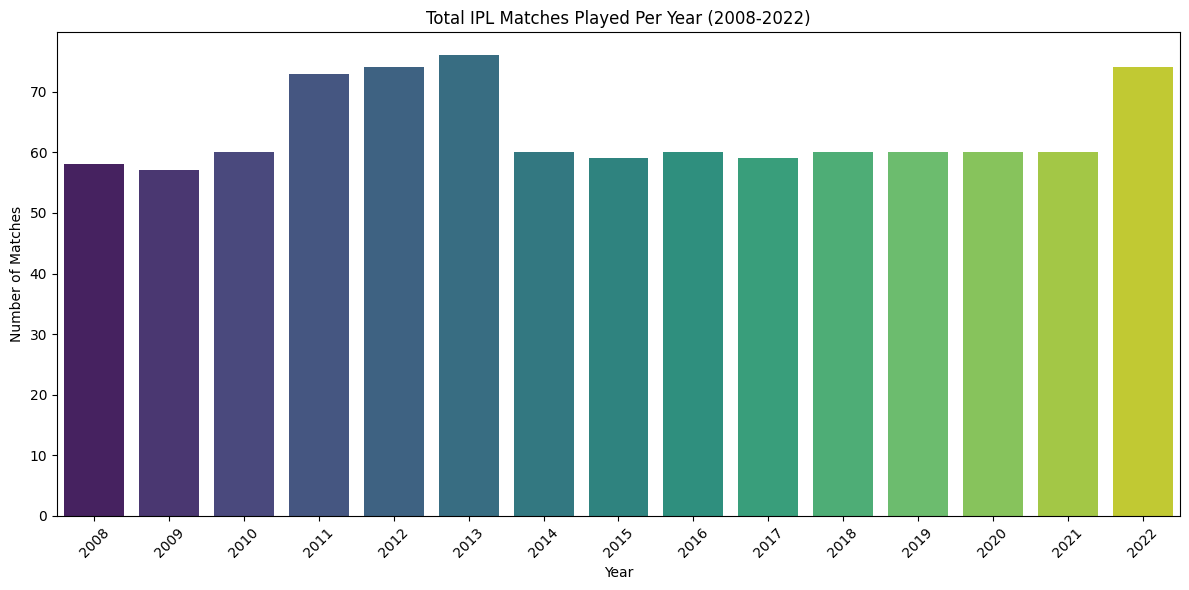


--- Data File for Matches per Year ---
Saved matches_per_year.csv

--- Bar Chart for Matches per Year ---
Saved matches_per_year_bar_chart.png


In [18]:
# Plotting Matches per Year
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='Total Matches', data=matches_per_year, palette='viridis')
plt.title('Total IPL Matches Played Per Year (2008-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('matches_per_year_bar_chart.png')
plt.show()
plt.close()

print("\n--- Data File for Matches per Year ---")
print("Saved matches_per_year.csv")
print("\n--- Bar Chart for Matches per Year ---")
print("Saved matches_per_year_bar_chart.png")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\3770042523.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Wins', y='Team', data=top_teams, palette='mako')


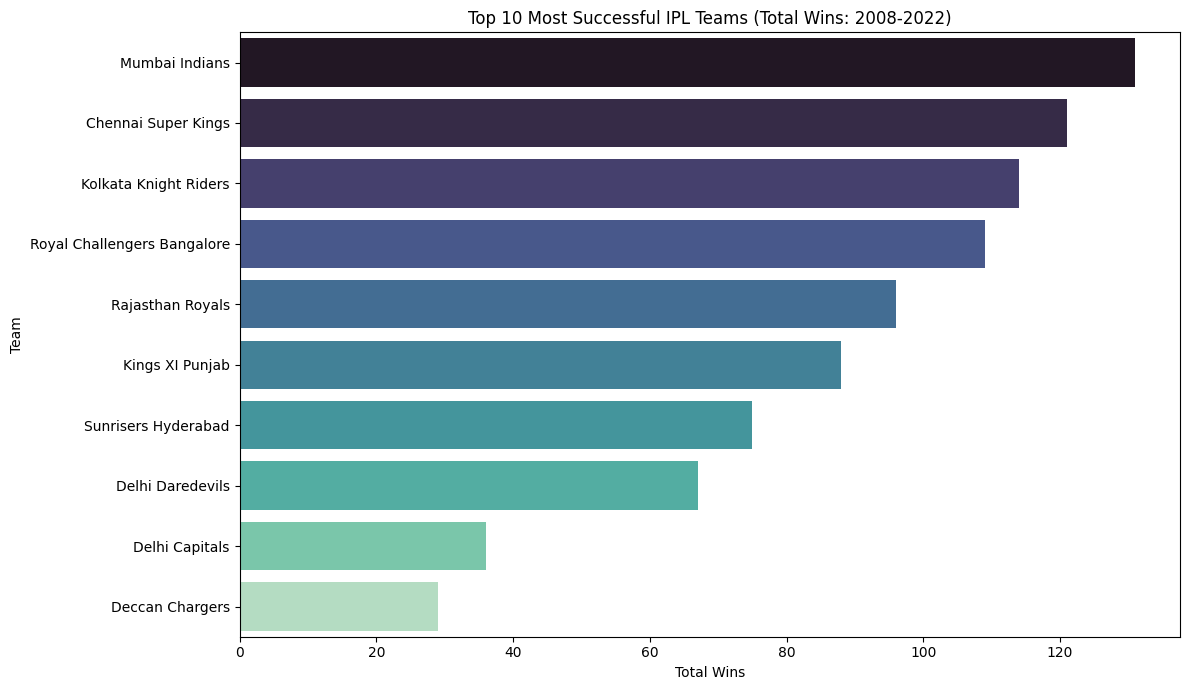


--- Data File for Top Winning Teams ---
Saved top_winning_teams.csv

--- Bar Chart for Top Winning Teams ---
Saved top_winning_teams_bar_chart.png


In [20]:
#Data Exploration 2: Most Successful Teams (Total Wins)

# Count wins for each team
most_successful_teams = df_matches['winning_team'].value_counts().reset_index()
most_successful_teams.columns = ['Team', 'Total Wins']

# Sort by Total Wins and select the top 10 for better visualization
top_teams = most_successful_teams.sort_values(by='Total Wins', ascending=False).head(10)

# Save the data for bar chart
top_teams.to_csv('top_winning_teams.csv', index=False)

# Plotting Most Successful Teams
plt.figure(figsize=(12, 7))
sns.barplot(x='Total Wins', y='Team', data=top_teams, palette='mako')
plt.title('Top 10 Most Successful IPL Teams (Total Wins: 2008-2022)')
plt.xlabel('Total Wins')
plt.ylabel('Team')
plt.tight_layout()
plt.savefig('top_winning_teams_bar_chart.png')
plt.show()
plt.close()

print("\n--- Data File for Top Winning Teams ---")
print("Saved top_winning_teams.csv")
print("\n--- Bar Chart for Top Winning Teams ---")
print("Saved top_winning_teams_bar_chart.png")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\874706266.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='POTM Awards', y='Player', data=top_players, palette='rocket')


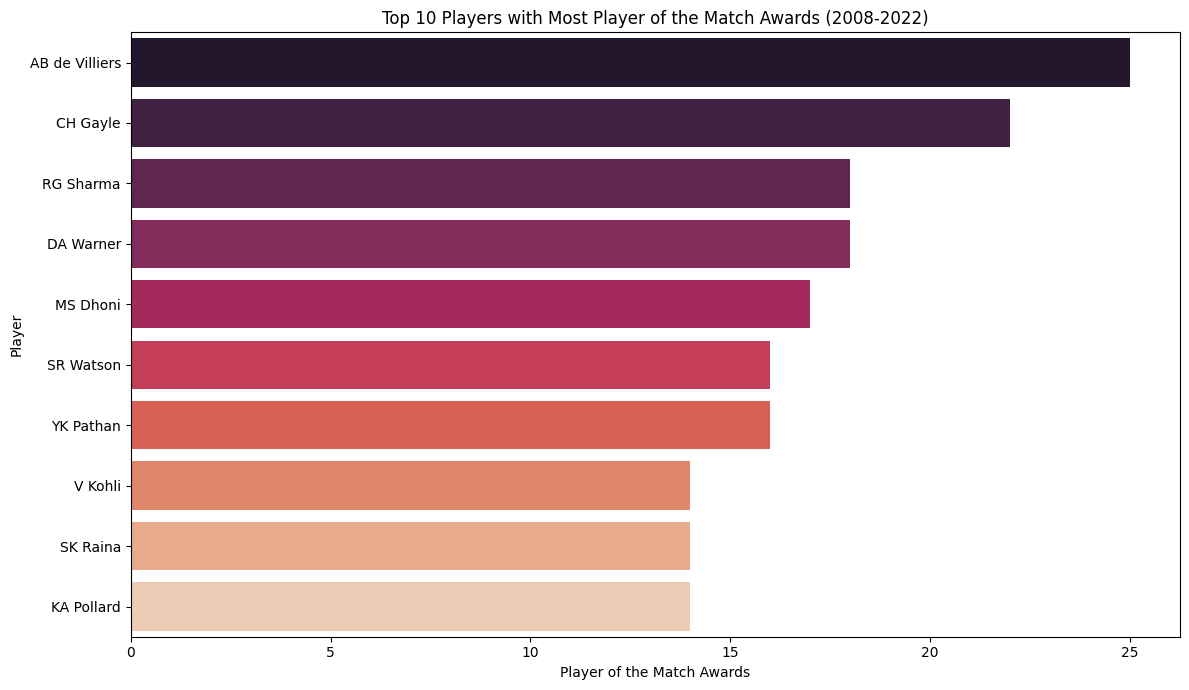


--- Data File for Top Player of the Match ---
Saved top_player_of_match.csv

--- Bar Chart for Top Player of the Match ---
Saved top_player_of_match_bar_chart.png


In [21]:
# Data Exploration 3: Most Common 'Player of the Match' (Top 10)

# Count 'Player of the Match' awards
top_players = df_matches['player_of_match'].value_counts().reset_index()
top_players.columns = ['Player', 'POTM Awards']

# Select the top 10
top_players = top_players.sort_values(by='POTM Awards', ascending=False).head(10)

# Save the data for bar chart
top_players.to_csv('top_player_of_match.csv', index=False)

# Plotting Most Common 'Player of the Match'
plt.figure(figsize=(12, 7))
sns.barplot(x='POTM Awards', y='Player', data=top_players, palette='rocket')
plt.title('Top 10 Players with Most Player of the Match Awards (2008-2022)')
plt.xlabel('Player of the Match Awards')
plt.ylabel('Player')
plt.tight_layout()
plt.savefig('top_player_of_match_bar_chart.png')
plt.show()
plt.close()

print("\n--- Data File for Top Player of the Match ---")
print("Saved top_player_of_match.csv")
print("\n--- Bar Chart for Top Player of the Match ---")
print("Saved top_player_of_match_bar_chart.png")

In [22]:
# Data Transformation: Merging DataFrames
df_merged = pd.merge(df_matches, df_balls, on='id', how='inner')

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\3831646639.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Runs', y='batter', data=top_batsmen, palette='YlOrRd')


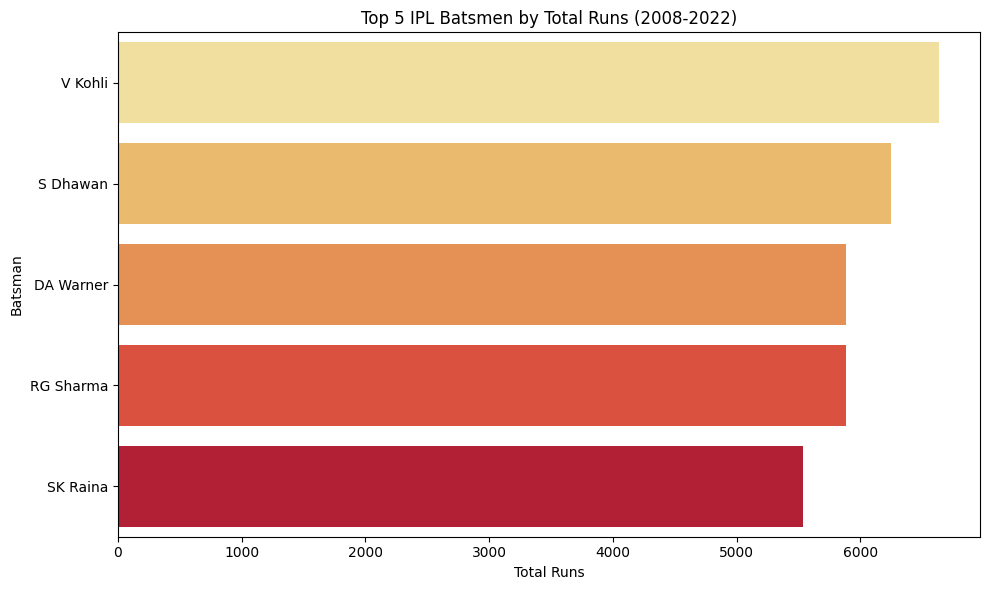


--- Data File for Top Batsmen Runs ---
Saved top_batsmen_runs.csv

--- Bar Chart for Top Batsmen Runs ---
Saved top_batsmen_runs_bar_chart.png


In [23]:
# Data Exploration 4: Top 5 Batsmen by Total Runs

# Calculate total runs for each batter
batsman_runs = df_merged.groupby('batter')['batsman_run'].sum().reset_index(name='Total Runs')

# Select top 5
top_batsmen = batsman_runs.sort_values(by='Total Runs', ascending=False).head(5)

# Save the data for bar chart
top_batsmen.to_csv('top_batsmen_runs.csv', index=False)

# Plotting Top Batsmen by Total Runs
plt.figure(figsize=(10, 6))
sns.barplot(x='Total Runs', y='batter', data=top_batsmen, palette='YlOrRd')
plt.title('Top 5 IPL Batsmen by Total Runs (2008-2022)')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.tight_layout()
plt.savefig('top_batsmen_runs_bar_chart.png')
plt.show()
plt.close()

print("\n--- Data File for Top Batsmen Runs ---")
print("Saved top_batsmen_runs.csv")
print("\n--- Bar Chart for Top Batsmen Runs ---")
print("Saved top_batsmen_runs_bar_chart.png")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21048\3953453516.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Wickets', y='bowler', data=top_bowlers, palette='Blues_d')


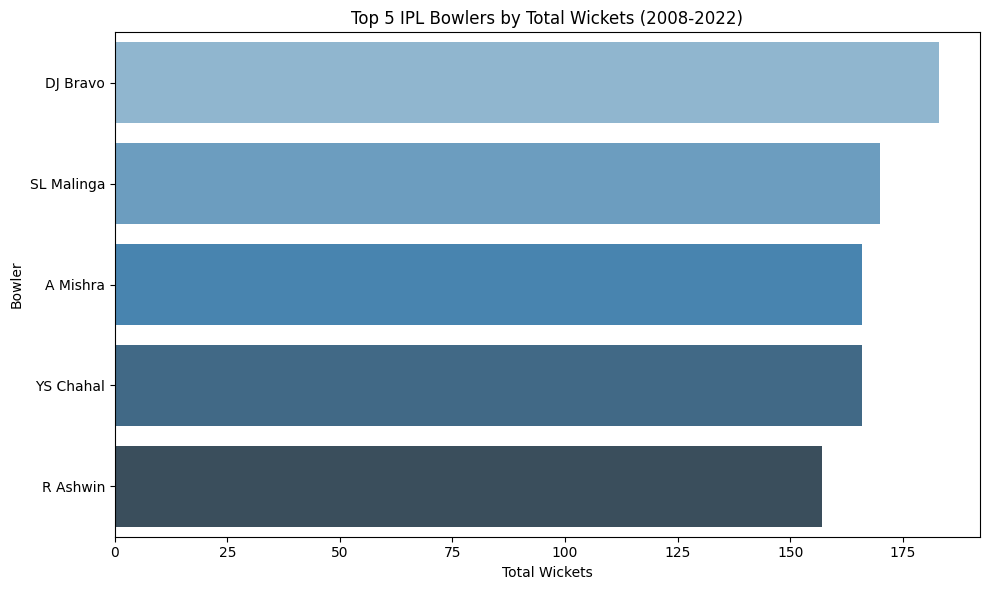


--- Data File for Top Bowlers Wickets ---
Saved top_bowlers_wickets.csv

--- Bar Chart for Top Bowlers Wickets ---
Saved top_bowlers_wickets_bar_chart.png


In [24]:
# Data Exploration 5: Top 5 Bowlers by Total Wickets

# Define bowler wickets (excluding run out, retired hurt, etc.)
bowler_dismissals = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
df_bowler_wickets = df_merged[df_merged['dismisal_kind'].isin(bowler_dismissals)]

# Count wickets for each bowler
bowler_wickets = df_bowler_wickets.groupby('bowler').size().reset_index(name='Total Wickets')

# Select top 5
top_bowlers = bowler_wickets.sort_values(by='Total Wickets', ascending=False).head(5)

# Save the data for bar chart
top_bowlers.to_csv('top_bowlers_wickets.csv', index=False)

# Plotting Top Bowlers by Total Wickets
plt.figure(figsize=(10, 6))
sns.barplot(x='Total Wickets', y='bowler', data=top_bowlers, palette='Blues_d')
plt.title('Top 5 IPL Bowlers by Total Wickets (2008-2022)')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.tight_layout()
plt.savefig('top_bowlers_wickets_bar_chart.png')
plt.show()
plt.close()

print("\n--- Data File for Top Bowlers Wickets ---")
print("Saved top_bowlers_wickets.csv")
print("\n--- Bar Chart for Top Bowlers Wickets ---")
print("Saved top_bowlers_wickets_bar_chart.png")